In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

Using TensorFlow backend.


## Data Prepration for India
Data is imported from John Hopkins GitHub Repo and can be used for more analysis

In [2]:
confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
deaths_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recoveries_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')

na_columns = (confirmed_df.isna().sum() / confirmed_df.shape[0]) > 0.99
na_columns = na_columns[na_columns]

confirmed_df = confirmed_df.drop(na_columns.index, axis=1)
deaths_df = deaths_df.drop(na_columns.index, axis=1)
recoveries_df = recoveries_df.drop(na_columns.index, axis=1)

## Tidy up the data
confirmed_df = confirmed_df.melt(id_vars=['Country/Region', 'Province/State', 'Lat', 'Long'], var_name='date', value_name='confirmed')
deaths_df = deaths_df.melt(id_vars=['Country/Region', 'Province/State', 'Lat', 'Long'], var_name='date', value_name='deaths')
recoveries_df = recoveries_df.melt(id_vars=['Country/Region', 'Province/State', 'Lat', 'Long'], var_name='date', value_name='recoveries')

confirmed_df['date'] = pd.to_datetime(confirmed_df['date'])
deaths_df['date'] = pd.to_datetime(deaths_df['date'])
recoveries_df['date'] = pd.to_datetime(recoveries_df['date'])

full_df = confirmed_df.merge(recoveries_df).merge(deaths_df)
full_df = full_df.rename(columns={'Country/Region': 'Country', 'date': 'Date', 'confirmed': "Confirmed", "recoveries": "Recoveries", "deaths": "Deaths"})
# Check null values
full_df.isnull().sum()

df_india=full_df[full_df['Country']=='India']

world_df = full_df.groupby(['Date']).agg({'Confirmed': ['sum'], 'Recoveries': ['sum'], 'Deaths': ['sum']}).reset_index()
world_df.columns = world_df.columns.get_level_values(0)

def add_rates(df):
    df['Confirmed Change'] = df['Confirmed'].diff().shift(-1)
 
    df['Mortality Rate'] = df['Deaths'] / df['Confirmed']
    df['Recovery Rate'] = df['Recoveries'] / df['Confirmed']
    df['Growth Rate'] = df['Confirmed Change'] / df['Confirmed']
    df['Growth Rate Change'] = df['Growth Rate'].diff().shift(-1)
    df['Growth Rate Accel'] = df['Growth Rate Change'] / df['Growth Rate']
    return df

df_india=add_rates(df_india)
df=pd.DataFrame(df_india['Confirmed'])
df = df.replace(0, np.nan)
df.dropna(axis=0,inplace=True)
df.reset_index(inplace=True)
#df.drop('index',axis=1,inplace=True)

df['index']=pd.Series(range(1,len(df)+1))
print(df)

Country               0
Province/State    22050
Lat                   0
Long                  0
Date                  0
Confirmed             0
Recoveries            0
Deaths                0
dtype: int64

     index  Confirmed
0        1        1.0
1        2        1.0
2        3        1.0
3        4        2.0
4        5        3.0
..     ...        ...
113    114   124794.0
114    115   131423.0
115    116   138536.0
116    117   144950.0
117    118   150793.0

[118 rows x 2 columns]


In [3]:
df_india=add_rates(df_india)

In [4]:
df=pd.DataFrame(df_india['Confirmed'])

In [5]:
df = df.replace(0, np.nan)
df.dropna(axis=0,inplace=True)
df.reset_index(inplace=True)
df.drop('index',axis=1,inplace=True)

In [6]:
#df['index']=pd.Series(range(1,len(df)+1))

## Data Prepration to feed LSTM Model

In [7]:
data=df.values

In [8]:
np.set_printoptions(suppress=True)

In [9]:
train=data[0:100]
test=data[100:]

In [10]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
Train = sc.fit_transform(train)

Here for ever 5 data point model will learn to predict next value and in this way data is prepared here

In [11]:
X_Train = []
Y_Train = []

for i in range(5, Train.shape[0]):
    
    X_Train.append(Train[i-5:i,0])
    
    Y_Train.append(Train[i,0])

# Convert into Numpy Array
X_Train = np.array(X_Train)
Y_Train = np.array(Y_Train)

print(X_Train.shape)
print(Y_Train.shape)

(95, 5)
(95,)


In [12]:
X_Train = np.reshape(X_Train, newshape=(X_Train.shape[0], X_Train.shape[1], 1))

## Stacked LSTM Model

In [13]:
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_Train.shape[1], 1)))
regressor.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [14]:
regressor.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 5, 50)             10400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 50)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 5, 50)             20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 5, 50)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 5, 50)             20200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 5, 50)             0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 50)               

In [15]:
regressor.fit(X_Train, Y_Train, epochs = 30, batch_size = 16)

Epoch 1/30
95/95 [==============================] - 2s 19ms/step - loss: 0.0765
Epoch 2/30
95/95 [==============================] - 0s 1ms/step - loss: 0.0610
Epoch 3/30
95/95 [==============================] - 0s 968us/step - loss: 0.0547
Epoch 4/30
95/95 [==============================] - 0s 1ms/step - loss: 0.0445
Epoch 5/30
95/95 [==============================] - 0s 1ms/step - loss: 0.0303
Epoch 6/30
95/95 [==============================] - 0s 1ms/step - loss: 0.0066
Epoch 7/30
95/95 [==============================] - 0s 1ms/step - loss: 0.0065
Epoch 8/30
95/95 [==============================] - 0s 1ms/step - loss: 0.0043
Epoch 9/30
95/95 [==============================] - 0s 1ms/step - loss: 0.0026
Epoch 10/30
95/95 [==============================] - 0s 1ms/step - loss: 0.0031
Epoch 11/30
95/95 [==============================] - 0s 999us/step - loss: 0.0016
Epoch 12/30
95/95 [==============================] - 0s 1ms/step - loss: 0.0019
Epoch 13/30
95/95 [=========================

In [16]:
hist=regressor.history

Text(0, 0.5, 'Loss')

Text(0.5, 0, 'epoch')

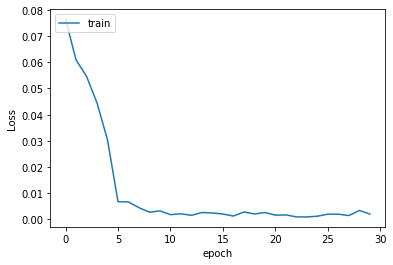

In [17]:
plt.plot(hist.history['loss'])
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [18]:
# We need to Reshape
test= test.reshape(-1,1)

# Normalize the Dataset
test = sc.transform(test)

X_test = []
for i in range(5,len(test)):
    X_test.append(test[i-5:i, 0])
    
# Convert into Numpy Array
X_test = np.array(X_test)

# Reshape before Passing to Network
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Pass to Model 
predicted_cases = regressor.predict(X_test)

# Do inverse Transformation to get Values 
predicted_cases = sc.inverse_transform(predicted_cases)

In [20]:
test=sc.inverse_transform(test)

Text(0, 0.5, 'No of Cases')

Text(0.5, 0, 'No. of days after 9 May')

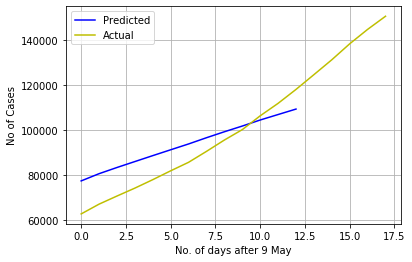

In [26]:
plt.plot(predicted_cases,c='b')
plt.plot(test,c='y')
plt.ylabel('No of Cases')
plt.xlabel('No. of days after 9 May')
plt.legend(['Predicted', 'Actual'], loc='upper left')
plt.grid()
plt.show()